### Preparation (Import Packages)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_plink import read_plink1_bin
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from collections import Counter
import seaborn as sns

import sys, ast
sys.path.insert(0, '../src/')
from annotation import *
from BANN import * # Import annotation code

sys.path.insert(0, '../examples_docs/')

import magenpy as mgp
import viprs as vp

2022-11-30 21:26:43.947759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u/local/apps/python/3.9.6/gcc-4.8.5/lib:/u/local/compilers/intel/2020.4/compilers_and_libraries_2020.4.304/linux/compiler/lib/intel64_lin:/u/local/compilers/intel/2020.4/compilers_and_libraries_2020.4.304/linux/daal/../tbb/lib/intel64_lin/gcc4.4:/u/local/compilers/intel/2020.4/compilers_and_libraries_2020.4.304/linux/daal/../tbb/lib/intel64_lin/gcc4.8:/u/local/compilers/intel/2020.4/compilers_and_libraries_2020.4.304/linux/daal/lib/intel64_lin:/u/local/compilers/intel/2020.4/compilers_and_libraries_2020.4.304/linux/ipp/../tbb/lib/intel64/gcc4.8:/u/local/compilers/intel/2020.4/compilers_and_libraries_2020.4.304/linux/ipp/lib/intel64:/u/local/compilers/intel/2020.4/compilers_and_libraries_2020.4.304/linux/mkl/lib/intel64_lin:/u/local/compilers

In [2]:
class RFF_gpytorch:

    def __init__(self, gamma, n_components,seed=None):
        assert n_components%2 ==0
        self.gamma = gamma
        self.n_components = n_components
        self.seed = seed

    def fit(self,X):
        seed = self.seed
        D = self.n_components
        M = X.shape[1]
        self.X = X
        self.M = M
        if seed is not None:
            np.random.seed(seed)
        W = np.random.standard_normal((M,D//2))
        self.W = W
        self.seed = seed
    
    def transform(self, X, active_dims=None):
        if active_dims is None:

            active_dims = np.array([True for i in range(X.shape[1])])
        
        W = self.W[active_dims,0:int(self.n_components//2 * np.mean(active_dims))]
        X = X[:,active_dims]
        D = int(self.n_components*np.mean(active_dims))
        gamma = self.gamma
        W = np.sqrt(2*gamma)*W
        projection = X@W
        sin = np.sin(projection)
        cos = np.cos(projection)
        Combine = np.empty((sin.shape[0],2*sin.shape[1]), dtype=float)
        Combine[:,0::2] = sin
        Combine[:,1::2] = cos
        Combine *= np.sqrt(2.)/np.sqrt(D)

        return np.float32(Combine)
        
    def fit_transform(self,X,active_dims=None):
        if active_dims is None:
            active_dims = np.array([True for i in range(X.shape[1])])
        

        seed = self.seed
        X = X[:,active_dims]
        self.X = X
        gamma = self.gamma
        D = int(self.n_components//2*np.mean(active_dims))
        if seed is not None:
            np.random.seed(seed)
        M = X.shape[1]
        W = np.random.standard_normal((M,D//2))*np.sqrt(2*gamma)
        self.W = W
        projection = X@W
        sin = np.sin(projection)
        cos = np.cos(projection)
        Combine = np.empty((sin.shape[0],2*sin.shape[1]), dtype=float)
        Combine[:,0::2] = sin
        Combine[:,1::2] = cos
        Combine *= np.sqrt(2.)/np.sqrt(D)
        return np.float32(Combine)

### Gene Annotation

In [3]:
chr_selected = "22"

data_folder = "/u/home/z/zhengton/project-sriram/CS-M226-Project/data/"

genotype_prefix = "chr22_filtered/1000G_eur_chr22"
# data_folder = "/u/home/z/zhengton/project-sriram/CS-M226-Project/data/"

# genotype_prefix = "sample_data/1000G_eur_chr22"

path_to_SNPList = data_folder+genotype_prefix+".map"
path_to_geneList = data_folder+"gene_list.txt"
path_to_selected_geneList = data_folder+f"gene_list_chr{chr_selected}.txt"
file_to_annotationDF=data_folder+f"AnnotationDF_chr{chr_selected}.txt"

In [4]:
# geneList_DF = pd.read_csv(path_to_geneList, sep='\t', header=None)
# geneList_DF.columns = ["Chromosome", "Start", "End", "GeneID"]
# selected_geneList_DF = geneList_DF[geneList_DF.Chromosome == chr_selected]

selected_geneList_DF = pd.read_csv(path_to_selected_geneList, sep='\t', header=None)
selected_geneList_DF.columns = ["Chromosome", "Start", "End", "GeneID"]

In [5]:
selected_geneList_DF

,Chromosome,Start,End,GeneID
0,22,42692120,42720870,A4GALT
1,22,41469124,41528989,ACO2
2,22,50738223,50745299,ACR
3,22,50481555,50486437,ADM2
4,22,24423596,24442361,ADORA2A
...,...,...,...,...
589,22,20394114,20408463,ZNF74
590,22,22513735,22520281,ZNF280A
591,22,22484425,22509187,ZNF280B
592,22,28883766,29057488,ZNRF3


In [6]:
path_to_filtered_geneList = data_folder+"/filtered_gene_list.txt"
filtered_geneList_DF = selected_geneList_DF
filtered_geneList_DF
filtered_geneList_DF.to_csv(path_to_filtered_geneList, header=None, index=False, sep='\t')

In [7]:
annotationDF=annotate(path_to_SNPList, path_to_filtered_geneList, outputFile=file_to_annotationDF, 
                      intergenic=False, buffer=500, dropSingletons=True)

print(annotationDF)

You have chosen to annotate SNP-sets without intergenic regions and with a buffer of 500bp
Annotating SNP-sets with the corresponding SNPs


100% 926/926 [00:01<00:00, 724.51it/s]


Dropping SNP-sets that are singletons (containing only one SNP) and re-annotating SNPs without them
Annotating SNP-sets with the corresponding SNPs


100% 926/926 [00:01<00:00, 776.71it/s]

Saving annotation results to file /u/home/z/zhengton/project-sriram/CS-M226-Project/data/AnnotationDF_chr22.txt
        GeneID Chromosome       Start         End  \
0        CECR7         22  17036569.0  17058792.0   
1       IL17RA         22  17084958.0  17115694.0   
2        CECR5         22  17137519.0  17165287.0   
3        CECR1         22  17178789.0  17221854.0   
4        CECR2         22  17359948.0  17558155.0   
..         ...        ...         ...         ...   
299      SYCE3         22  50551111.0  50562899.0   
300   MAPK8IP2         22  50600684.0  50611551.0   
301       ARSA         22  50622753.0  50628173.0   
302     SHANK3         22  50674641.0  50733212.0   
303  RPL23AP82         22  50757085.0  50799637.0   

                                           SNPindex  \
0                                         [0, 1, 2]   
1                                            [3, 4]   
2                                               [5]   
3                              

In [ ]:
# annotationDF = pd.read_csv(file_to_annotationDF, index_col=0, sep='\t')
# selected_annotationDF = annotationDF[annotationDF.Chromosome == int(chr_selected)]
# selected_annotationDF.SNPindex = selected_annotationDF.SNPindex.apply(lambda x: np.array(ast.literal_eval(x)) - selected_SNPList_DF.index[0])
# selected_annotationDF.VariantID = selected_annotationDF.VariantID.apply(lambda x: ast.literal_eval(x))
# selected_annotationDF = selected_annotationDF.reset_index().drop(columns=['index'])

# selected_SNPList_DF = selected_SNPList_DF.reset_index().drop(columns=['index'])

In [8]:
mask_outputFile=data_folder+f"chr{chr_selected}_Mask.txt"
mask = getMaskMatrix(path_to_SNPList, annotationDF, mask_outputFile)
print(mask)

creating mask


100% 304/304 [00:00<00:00, 10118.95it/s]


Saving annotation mask to file /u/home/z/zhengton/project-sriram/CS-M226-Project/data/chr22_Mask.txt in tab-delimited format
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [9]:
mask_outputFile=data_folder+f"chr{chr_selected}_Mask.txt"
mask = np.loadtxt(mask_outputFile)
mask

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Load Genotype

In [11]:
bfile=data_folder+genotype_prefix

bed = bfile+'.bed'
fam = bfile+'.fam'
bim = bfile+'.bim'

G = read_plink1_bin(bed, bim, fam, verbose=True)

Mapping files: 100% 3/3 [00:00<00:00, 112.75it/s]


In [12]:
# sub_G = G.where(G.chrom == chr_selected, drop=True)
# sub_G
G

<xarray.DataArray 'genotype' (sample: 378, variant: 926)>
dask.array<transpose, shape=(378, 926), dtype=float32, chunksize=(378, 926), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object 'HG00096' 'HG00097' ... 'NA20826' 'NA20828'
  * variant  (variant) <U10 'variant0' 'variant1' ... 'variant924' 'variant925'
    fid      (sample) object 'HG00096' 'HG00097' ... 'NA20826' 'NA20828'
    iid      (sample) object 'HG00096' 'HG00097' ... 'NA20826' 'NA20828'
    father   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) object '-9' '-9' '-9' '-9' '-9' ... '-9' '-9' '-9' '-9'
    chrom    (variant) object '22' '22' '22' '22' '22' ... '22' '22' '22' '22'
    snp      (variant) object 'rs9605903' 'rs5746647' ... 'rs28642259'
    cm       (variant) float64 2.336 2.34 2.344 2.441 ... 74.26 74.28 74.37
    pos      (variant) int32 17054720 17057138 17058616 ... 50725301 50785718
    a0       (variant) object 'C' 'G' 'T' 'C' 'A' 'G' ... 'T' 'C' 'A' 'A' 'T'
    a1       (variant) object 'T' 'T' 'C' 'A' 'C' 'A' ... 'G' 'T' 'G' 'G' 'C'

In [14]:
X = G.values

print(X.shape)
N, p = X.shape

(378, 926)


In [15]:
corr_mat_pd = pd.DataFrame(X).corr()

<AxesSubplot:>

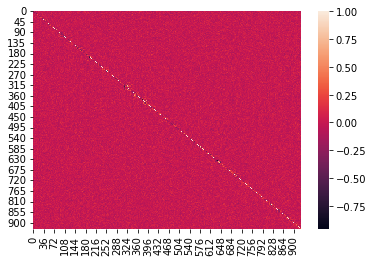

In [16]:
sns.heatmap(corr_mat_pd)

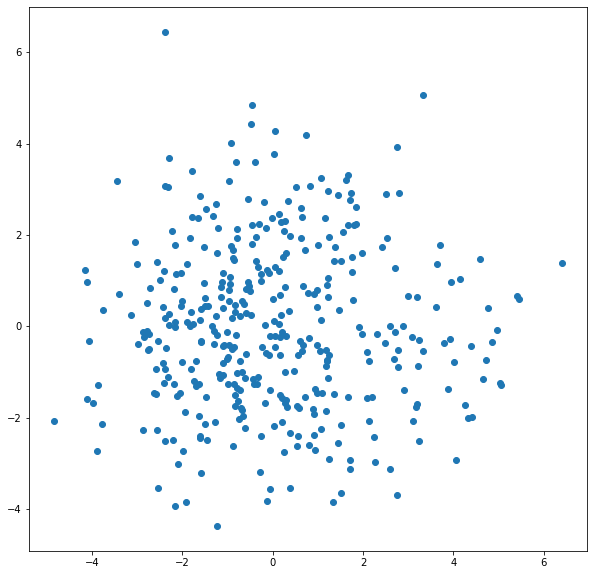

In [17]:
pca = PCA(n_components=2)
geno_mat_transformed = pca.fit_transform(X)

# population_labels = y

plt.figure(figsize=(10, 10))

plt.scatter(geno_mat_transformed[:, 0], geno_mat_transformed[:, 1])

In [18]:
PCs = np.column_stack([geno_mat_transformed[:, 0], geno_mat_transformed[:, 1]])
# X = X - PCs @ (np.linalg.inv(PCs.T @ PCs) @ (PCs.T @ X))

### Subsample Genotype

In [9]:
# p = 5000
# nSNPs= p

# subset_X = X[:, :p]
# subset_mask = mask[:p, :]
# subset_mask = subset_mask[:, subset_mask.any(0)]

### Simulate Phenotypes

In [19]:
############### SIMULATING PHENOTYPES #################
# Defining the parameters of the phenotype simulations:

H2 = 0.6 #Broad-sense heritability, meaning 60% of phenotypic variation is explained by genotypic variation.
rho= 0.5 #All of the heritability comes from additive effects
causal_indices=np.arange(0,np.int32(0.1*p)) #Pick the first 10 of 1000 SNPs to have non-zero effect sizes
ncausal=len(causal_indices)

# Simulate phenotype data based on additive effects:

Xadditive=X[:, causal_indices] # Get the causal SNP values
betaAdd= np.repeat(1, ncausal)# Initialize all effect sizes for these SNPs as "1"
#Initialize the value of the portion of phenotypic variation explained by the additive effects as XB:
y_additive=np.dot(Xadditive, betaAdd)
# Re-scale additive effect sizes based on H^2*rho:
betaAdd= betaAdd * np.sqrt(H2*rho/np.var(y_additive))
# Update y_additive based on effect sizes:
y_additive=np.dot(Xadditive, betaAdd) 


Xepi=[]
for i in causal_indices:
    for j in range(i+1, causal_indices[-1]+1):
        Xepi.append(np.multiply(X[:, i], X[:, j]))
Xepi=np.column_stack(Xepi) #Matrix that holds the values for 
# pairwise interactions between all causal SNPs.

betaEpi= (np.array([1]*Xepi.shape[1])).reshape(-1,1) #Similar to the additive effects,
# epistatic effect sizes are initialized as 1 and will be corrected below.
y_epi= np.dot(Xepi, betaEpi)
betaEpi= betaEpi* np.sqrt(H2*(1-rho)/np.var(y_epi))
y_epi= np.dot(Xepi, betaEpi) # Final value for the portion of phenotypes explained by
#the epistatic effects



# Simulate random noise (drawn from standard normal distribution) for the rest of phenotypic variation (40%):
y_noise = np.random.normal(size=N)
y_noise = y_noise * np.sqrt((1 - H2) / np.var(y_noise))

# Add y_additive and y_noise to get the final simulated phenotypes:
# y = np.add(y_additive.reshape(N, 1), y_noise.reshape(N, 1)) 
y = np.add(y_additive.reshape(N, 1),y_epi.reshape(N, 1), y_noise.reshape(N, 1)) 
print("Shape of the phenotype array:", y.shape)

Shape of the phenotype array: (378, 1)


In [34]:
causal_genes = np.unique(np.concatenate(list(map(lambda x: np.where(x == 1)[0], mask[causal_indices]))))

In [36]:
causal_genes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [35]:
# np.savetxt("X.txt", subset_X, delimiter=" ")
np.savetxt("y_pairwise.txt", y, delimiter=" ")

In [49]:
# %%capture
# !pip uninstall --y tensorflow
# !pip install tensorflow

In [76]:
# y_res = y - PCs @ (np.linalg.inv(PCs.T @ PCs) @ (PCs.T @ y))
# X_res = X - PCs @ (np.linalg.inv(PCs.T @ PCs) @ (PCs.T @ X))
# np.savetxt("y_res.txt", y, delimiter=" ")

Welcome to BANNs. Please make sure SNPs in the SNP List you provide are in the same order as in the genotype matrix. Results we return will be in the order of SNP annotations and SNP-set annotations.
Invalid epi_p input, ignoring this parameter
(378,)
100/100 [==============================] - 209s 2s/step
(378, 304)
(378,)
100/100 [==============================] - 14s 140ms/step
constructing kernelized features...
304/304 [==============================] - 0s 67us/step
start optional layer: SET_nonlinear_layer...
(378,)
100/100 [==============================] - 187s 2s/step
PVE
0.4326326467755528
0.44188479358458965
0.09375916751957396


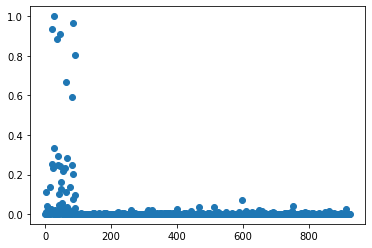

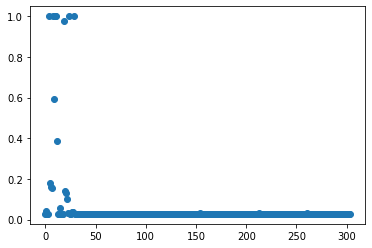

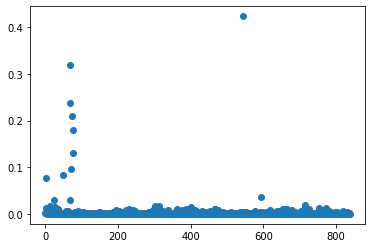

In [37]:
# X = np.loadtxt("X.txt")
y = np.loadtxt("y_pairwise.txt")
# y_res = np.loadtxt("y_res.txt")
mask = np.loadtxt(data_folder+f"chr{chr_selected}_Mask.txt")

bann=BANNs(X,y, mask, nModelsSNP=100, nModelsSET=100, nModelsSET_nonlinear=100, epi_p = 1)
[SNP_layer, SET_layer, SET_layer_nonlinear]=bann.run(nonlinear_flag=True)
print("PVE")
print(SNP_layer.pve)
print(SET_layer.pve)
print(SET_layer_nonlinear.pve)

SNPpips=SNP_layer.pip
SETpips=SET_layer.pip
SET_nonlinear_pips=SET_layer_nonlinear.pip

plt.scatter(np.arange(len(SNPpips)), SNPpips)
plt.show()

plt.scatter(np.arange(len(SETpips)), SETpips)
plt.show()

plt.scatter(np.arange(len(SET_nonlinear_pips)), SET_nonlinear_pips)
plt.show()

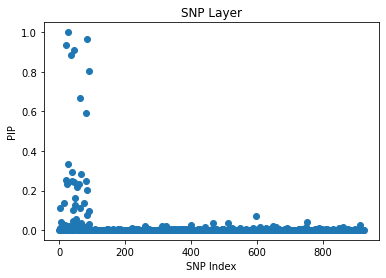

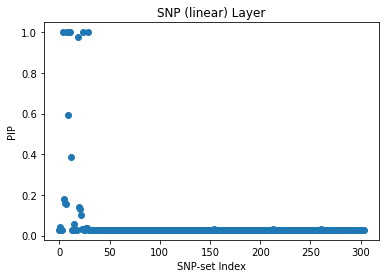

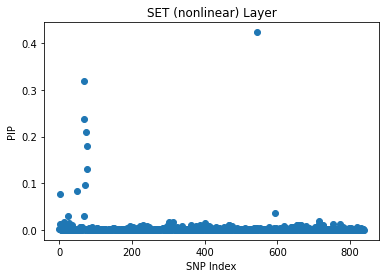

In [38]:
plt.scatter(np.arange(len(SNPpips)), SNPpips)
plt.xlabel("SNP Index")
plt.ylabel("PIP")
plt.title("SNP Layer")
plt.savefig("SNPpip_plot.png", dpi=300)
plt.show()

plt.scatter(np.arange(len(SETpips)), SETpips)
plt.xlabel("SNP-set Index")
plt.ylabel("PIP")
plt.title("SNP (linear) Layer")
plt.savefig("SETpip_plot.png", dpi=300)
plt.show()

plt.scatter(np.arange(len(SET_nonlinear_pips)), SET_nonlinear_pips)
plt.xlabel("SNP Index")
plt.ylabel("PIP")
plt.title("SET (nonlinear) Layer")
plt.savefig("SET_nonlinear_pip_plot.png", dpi=300)
plt.show()

### GWAS (linear regression)

In [20]:
gdl = mgp.GWADataLoader(bed_files=bfile)
gdl.set_phenotype(y)

gdl.compute_ld('shrinkage', output_dir='output/ld/',
               genetic_map_ne=11400, # effective population size (Ne)
               genetic_map_sample_size=183, # Sample size
               threshold=1e-3)

gdl.perform_gwas()
gdl.to_summary_statistics_table()

summ_table = gdl.to_summary_statistics_table()

> Reading BED file...
> Computing LD matrix...
> Performing GWAS...


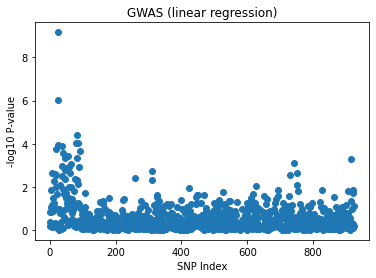

In [21]:
plt.scatter(np.arange(len(summ_table.PVAL.values)), -np.log10(summ_table.PVAL.values))
plt.xlabel("SNP Index")
plt.ylabel("-log10 P-value")
plt.title("GWAS (linear regression)")
plt.savefig("gwas_manhattan_plot.png", dpi=300)

### Computational Power
ROC curves

In [39]:
### ROC Curve
def draw_roc_curve(y_true_pred_dict, title=None):
    
    plt.figure()
    for method_name, (y_true, y_pred) in y_true_pred_dict.items():
        
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        # Compute micro-average ROC curve and ROC area
        
        lw = 2
        plt.plot(
            fpr,
            tpr,
            lw=lw,
            label=f"{method_name} (area = %0.2f)" % roc_auc,
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.05, 1.0])
        plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    if title is not None:
        plt.title(title)
    

In [46]:
nSNPs = X.shape[1]
nSets = bann.G.shape[1]

In [47]:
y_true_snp = np.zeros(nSNPs, dtype=int)
y_true_snp[causal_indices] = 1

y_true_gene = np.zeros(nSets, dtype=int)
y_true_gene[causal_genes] = 1

y_true_gene_nonlinear = np.zeros(np.sum(bann.num_nonlinear_relations, dtype=int), dtype=int)

for idx in causal_genes:
    len_nonlinear = bann.num_nonlinear_relations[idx]
    start_idx = np.sum(bann.num_nonlinear_relations[:idx], dtype=int)
    y_true_gene_nonlinear[start_idx:(start_idx+len_nonlinear)] = 1

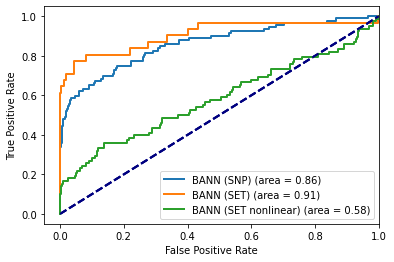

In [48]:
draw_roc_curve({"BANN (SNP)": (y_true_snp, SNPpips), "BANN (SET)": (y_true_gene, SETpips), "BANN (SET nonlinear)": (y_true_gene_nonlinear, SET_nonlinear_pips)})
plt.savefig("roc_curve.png", dpi=300)

In [ ]:
# for threshold in [0.1, 0.3, 0.5]:
#     y_bann_one_hot = {}
    
#     for layer, pips in {"BANN (SNP)": SNPpips, "BANN (SET)": SETpips, "BANN (SET_nonlinear)": SET_nonlinear_pips}.items():
#         pip_threshold = threshold
#         y_bann = np.zeros(num_snps, dtype=int)
#         if len(np.where(pips >= pip_threshold)[0]) > 1:
#             y_bann[np.where(pips >= pip_threshold)[0]] = 1

#             y_bann_one_hot[layer] = np.zeros((num_snps, 2), dtype=int)
#             y_bann_one_hot[layer][np.arange(num_snps), y_bann] = 1
#     y_bann_one_hot["GWAS"] = y_gwas_one_hot
#     draw_roc_curve(y_true_one_hot, y_bann_one_hot, f"ROC curve with PIP threshold={threshold}")
#     plt.savefig(f"roc_curve_pip_threshold={threshold}.png", dpi=300)

### archive code

In [23]:
# snp_clustering = DBSCAN(eps=0.1, min_samples=2).fit(SNPpips.reshape(-1, 1))
# dict_labels_snp = Counter(snp_clustering.labels_)
# del dict_labels_snp[-1]
# snp_level_indices = np.where(snp_clustering.labels_ == min(dict_labels_snp, key=dict_labels_snp.get))[0]
# set_clustering = DBSCAN(eps=0.1, min_samples=2).fit(SETpips.reshape(-1, 1))
# dict_labels_set = Counter(set_clustering.labels_)
# del dict_labels_set[-1]
# set_level_indices = np.where(set_clustering.labels_ == min(dict_labels_set, key=dict_labels_set.get))[0]
# potential_indices = np.sort(np.array(list(set(set_level_indices).union(snp_level_indices))))
# print(snp_level_indices)
# print(set_level_indices)
# print(potential_indices)

[   0    1    3    5    6   10   12   13   15   16   18   19   25   26
   29   30   31   34   35   37   39   41   42   44   46   49   51   52
   54   55   56   58   59   60   62   63   64   65   66   67   68   69
   71   73   74   75   76   77   80   81   83   84   86   87   88   89
   90   91   92   94  102  619 1895]
[ 0  7 21]
[   0    1    3    5    6    7   10   12   13   15   16   18   19   21
   25   26   29   30   31   34   35   37   39   41   42   44   46   49
   51   52   54   55   56   58   59   60   62   63   64   65   66   67
   68   69   71   73   74   75   76   77   80   81   83   84   86   87
   88   89   90   91   92   94  102  619 1895]


In [25]:
# nSets_selected = list(set(np.hstack(list(map(lambda x: np.where(x == 1)[0], subset_mask[potential_indices, :])))))
# if len(nSets_selected) <= 0:
#     print("no SNP Sets selected")
# elif len(nSets_selected) == 1:
#     potential_sets = np.array([nSets_selected[0]-1, nSets_selected[0]+1])
#     potential_sets = potential_sets[potential_sets >= 0]
#     potential_sets = potential_sets[potential_sets < selected_mask.shape[1]]
    
#     nSets_selected.extend(potential_sets)
# nSets_selected = np.sort(nSets_selected) 
# print(nSets_selected)

[ 0  7 21]


In [26]:
# potential_indices = np.concatenate([np.where(subset_mask[:, i] == 1)[0] for i in nSets_selected])
# print(len(potential_indices))

1260


In [27]:
# X_selected = subset_X[:, potential_indices]
# mask_selected = subset_mask[potential_indices, :]
# mask_selected = mask_selected[:, mask_selected.any(0)]
# nSets_selected = mask_selected.shape[1]

# for i in range(0, nSets_selected):
#     indices = np.where(mask_selected[:, i] == 1)[0]
#     if len(indices) <= 1:
#         X_selected = np.delete(X_selected, indices, axis=1)
#         mask_selected = np.delete(mask_selected, indices, axis=0)
        
        
# mask_selected = mask_selected[:, mask_selected.any(0)]
# nSets_selected = mask_selected.shape[1]

# X_epi = []
# num_feature_in_sets = []
# for i in range(0, nSets_selected):
#     indices = np.where(mask_selected[:, i] == 1)[0]
#     current_X = X_selected[:, indices]
    
#     Z = []
#     for i in range(len(indices)):
#         for j in range(i+1, len(indices)):
#             Z.append(np.multiply(current_X[:, i], current_X[:, j]))
#     Z  = np.column_stack(Z)
    
#     rff_kernel = RFF_gpytorch(gamma=0.1, n_components=4*len(indices),seed=111)
#     Z = rff_kernel.fit_transform(X_selected[:, indices])
    
#     X_epi.append(Z)
#     num_feature_in_sets.append(Z.shape[1])
    
# X_epi=np.column_stack(X_epi)
# dim_set = X_epi.shape[1]//nSets_selected ## number of features per SNP set

# mask_epi=np.zeros(shape=(sum(num_feature_in_sets),nSets_selected))

# start_idx = 0
# for i in range(0, nSets_selected):
#     num_features = num_feature_in_sets[i]
#     for j in range(start_idx, start_idx+num_features):
#         mask_epi[j] = np.zeros(nSets_selected)
#         mask_epi[j][i] = 1
#     start_idx += num_features
        

# print(mask_epi.shape)
# print(X_epi.shape)
# np.savetxt("X_epi_test2.txt", X_epi, delimiter=" ")
# np.savetxt("mask_epi_test2.txt",mask_epi, delimiter=" ")

(2520, 3)
(2504, 2520)


In [28]:
# X_epi = np.loadtxt("X_epi_test2.txt")
# y = np.loadtxt("ytest2.txt")
# mask_epi = np.loadtxt("mask_epi_test2.txt")

# bann_epi=BANNs(X_epi,y, mask_epi, nModelsSNP=20, nModelsSET=20)
# [SNP_layer_epi, SET_layer_epi]=bann_epi.run()
# print("PVE")
# print(SNP_layer_epi.pve)
# print(SET_layer_epi.pve)


# SNPpips_epi=SNP_layer_epi.pip
# SETpips_epi=SET_layer_epi.pip


Welcome to BANNs. Please make sure SNPs in the SNP List you provide are in the same order as in the genotype matrix. Results we return will be in the order of SNP annotations and SNP-set annotations.
(2504,)
20/20 [==============================] - 321s 16s/step
(2504, 3)
(2504,)
20/20 [==============================] - 0s 5ms/step
PVE
0.12700891191334318
0.1973736533443662


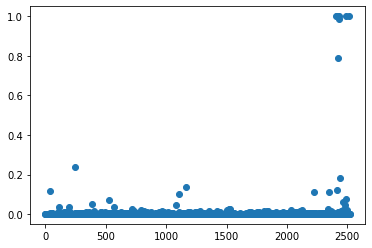

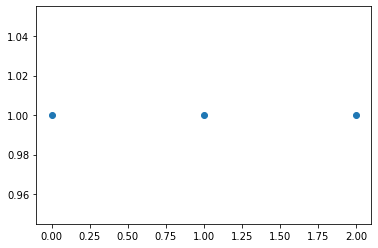

In [29]:
# plt.scatter(np.arange(len(SNPpips_epi)), SNPpips_epi)
# plt.show()

# plt.scatter(np.arange(len(SETpips_epi)), SETpips_epi)
# plt.show()

# print(SNP_layer.pve+SNP_layer_epi.pve)
# print(SET_layer.pve+SET_layer_epi.pve)
# SNPpips_epi=SNP_layer_epi.pip
# SETpips_epi=SET_layer_epi.pip

# clustering = DBSCAN(eps=0.1, min_samples=2).fit(SNPpips_epi.reshape(-1, 1))
# dict_labels_snp = Counter(clustering.labels_)
# del dict_labels_snp[-1]
# snp_level_indices = np.where(clustering.labels_ == min(dict_labels_snp, key=dict_labels_snp.get))[0]
# snp_level_indices